# Set The Model Here

In [ ]:
def Stock_Forecast(Instrument, TRIAL, PATIENCE, Back):

    # check if bdshare is installed if not install
    try:
      import bdshare
    except:
      !pip install bdshare
    
    # importing required libraries
    import pandas as pd
    import numpy as np
    import datetime
    import tensorflow as tf
    import keras
    import random as rn
    import os
    from sklearn.preprocessing import MinMaxScaler
    
    from tensorflow.keras import backend as K
    from tensorflow.keras.models import Sequential, load_model
    from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, TimeDistributed
    from tensorflow.keras.utils import plot_model
    from tensorflow.python.keras.callbacks import ModelCheckpoint
    from tensorflow.python.keras.callbacks import EarlyStopping
    
    from bdshare import get_hist_data
    
    import plotly.offline as py
    import plotly.graph_objs as go
    py.init_notebook_mode(connected=True)
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    # stop posting the warning
    os.environ["PYTHONHASHSEED"] = "0"
    import tensorflow.python.util.deprecation as deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False

    # Setting the seed for numpy-generated random numbers
    np.random.seed(37)

    # Setting the seed for python random numbers
    rn.seed(1254)

    # Setting the graph-level random seed. (tensorflow 2x)
    tf.random.set_seed(89)
    
    # tensorflow 2x change
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
    )

    # Force Tensorflow to use a single thread (tensorflow 2x)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.reset_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=session_conf))

    # read the data
    #d = pd.read_excel("Book3.xlsx")
    to_date = datetime.datetime.today()
    from_date = to_date - datetime.timedelta(days=365*2)
    df = get_hist_data(from_date,to_date,Instrument)
    df = df.reset_index()
    df["close"] = df["close"].astype(float)
    df.columns = ["DATE", "TRADING.CODE", "LTP", "HIGH", "LOW", "OPENP", "CLOSEP", "YCP", "TRADE", "VALUE", "VOLUME"]

    # remove leading and trainling blank spaces from column names
    df.columns = df.columns.str.strip()

    # remove leanding and trailing blank spaces from TRADING.CODEs
    df["TRADING.CODE"] = df["TRADING.CODE"].str.strip()

    # select the Instrument of your interest
    #df = d[d["TRADING.CODE"] == Instrument]

    # remove rows with invalid values
    df = df[
        ~(df["LTP"] == 0)
        | (df["HIGH"] == 0)
        | (df["LOW"] == 0)
        | (df["OPENP"] == 0)
        | (df["CLOSEP"] == 0)
    ]

    # sort the data as per date
    df = df.sort_values(["DATE"], ascending=True)
    
    # turn the date column into date format
    df['DATE'] = pd.to_datetime(df['DATE'])

    # keep only the required columns
    clean_data = df[["DATE", "CLOSEP"]]

    # set the date column as index
    clean_data.set_index(["DATE"], inplace=True)

    # turn the column into a numpy array
    close_price = clean_data.values

    # set first 85% values as training data and the rest as test data
    train = close_price[: int(len(close_price) * 0.85), :]
    valid = close_price[int(len(close_price) * 0.85) :, :]

    # scaling the values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_price)

    # creating x_train and y_train, seeting the array as 0 dimensional, each time x_train.append is giving 'Back' values with 0 dimension,then set each as
    # rows
    x_train, y_train = [], []
    for i in range(Back, len(train)):
        x_train.append(scaled_data[i - Back : i, 0])
        y_train.append(scaled_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    # turn x_train as three dimensional
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    # set name for the saved model
    saved_model = Instrument + "weights.hdf5"
    
    # tell the model to minimize mape
    model.compile(
        loss="mean_absolute_percentage_error", optimizer="adam"
    )  
    
    # tell the model to wait for the next PATIENCE model, if no improvement, stop
    ks = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", mode="auto", verbose=1, patience=PATIENCE
    )  
    
    # ask to save the best model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model, monitor="loss", verbose=0, save_best_only=True
    )  
    
    # now fit the model
    model.fit(
        x_train,
        y_train,
        epochs=TRIAL,
        validation_split=0.1,
        verbose=0,
        callbacks=[ks, checkpointer],
    )  
    
    # now the best model will be loaded from saved file
    model = load_model(saved_model)  

    # predicting values, using past 'Back' from the train data
    inputs = clean_data.values[len(clean_data) - len(valid) - Back :]
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    # creating X_test
    X_test = []
    for i in range(Back, inputs.shape[0]):
        X_test.append(inputs[i - Back : i, 0])
    X_test = np.array(X_test)

    # turn X_test into 3 dimensional
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # forecasting future values ie calculating y_test
    closing_price = model.predict(X_test)
    cl = closing_price

    # turning the forecasting values back to original scale
    closing_price = scaler.inverse_transform(closing_price)

    # model evaluate
    train_acc = model.evaluate(x_train, y_train, verbose=0)
    test_acc = model.evaluate(X_test, cl, verbose=0)
    # print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # calculating MAPE
    rms = np.sqrt(np.mean(np.power((valid - closing_price), 2)))
    mape = sum(abs(valid - closing_price) / abs(valid)) * 100 * (1 / len(valid))

#### Plot out of sample forecast ####
    plt.figure(figsize=(20, 10))
    train = clean_data[: int(len(close_price) * 0.85)]
    valid = clean_data[int(len(close_price) * 0.85) :]
    valid["Predictions"] = closing_price
    plt.plot(train["CLOSEP"])
    plt.plot(valid[["CLOSEP", "Predictions"]])
    plt.title("Out of Sample Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(["Train Set", "Test Set", "Forecasted Price"], prop={"size":15})

#### If you need the Plotly Interactive Chart ####
    # trace1 = go.Scatter(x=train.index, y=train["CLOSEP"], mode="lines", name="Train Set")
    # trace2 = go.Scatter(x=valid.index, y=valid["CLOSEP"], mode="lines", name="Test Set")
    # trace3 = go.Scatter(x=valid.index, y=valid["Predictions"], mode="lines", name="Predicted Values")
    # data = [trace1, trace2, trace3]
    # layout = go.Layout(title = "Out of Sample Forecast", 
    #               xaxis = dict(title = "Date"), 
    #               yaxis = dict(title = "Price"))
    # fig_test = go.Figure(data = data, layout = layout)
    # py.iplot(fig_test)
    
    print("The Root Mean Square of the Model is: %.3f" % (rms))
    print("The Mean Absolute Percentage Error of the Model is: %.3f" % (mape))

    # out of sample (beyond test set) forecast, next 30 business days
    last_values = scaled_data[-Back:]  # take last 'Back' values
    last_values = last_values.reshape((1, Back, 1))  # reshape
    yhat = np.zeros(shape=(30, 1))

    # run for loop for creating one forecast at a time and then use it to forecast the next
    for i in range(0, 30):
        yhat[i] = model.predict(last_values, verbose=0)
        last_values = np.append(last_values, yhat[i])[-Back:].reshape(1, Back, 1)

    yx = scaler.inverse_transform(yhat)  # inverse the variable transformation
    yx = np.concatenate(yx).ravel().tolist()  # unlist the forecast data
    yx = [round(w, 1) for w in yx]  # rounding the data to .10

    # create the date index of the forecasted values
    weekmask = "Sun Mon Tue Wed Thu"
    custombday = pd.offsets.CustomBusinessDay(weekmask=weekmask)
    pday = pd.bdate_range(
        start=df.iloc[clean_data.shape[0] - 1, 0] + datetime.timedelta(days=1),
        end=df.iloc[clean_data.shape[0] - 1, 0] + datetime.timedelta(days=365),
        freq=custombday,
    ).tolist()[0:30]

    # turn the forecasted values into a dataframe
    forecast_data = pd.DataFrame({"Date": pday, "Forecast": yx})
    forecast_data.set_index("Date", inplace=True)

    # now plot the forecast along with the original data
    comb_data = pd.merge(
        valid, forecast_data, left_index=True, right_index=True, how="outer"
    )
    
    plt.figure(figsize=(20, 10))
    plt.plot(comb_data[["CLOSEP", "Forecast"]])
    plt.title("Future Value Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Forecasted Price"], prop={"size":15})

#### For Plotly Interactive Charts ####
    # trace1 = go.Scatter(x=comb_data.index, y=comb_data["CLOSEP"], mode = "lines", name = "Actual Price")
    # trace2 = go.Scatter(x = comb_data.index, y = comb_data["Forecast"], mode = "lines", name = "Forecasted Values")
    # data = [trace1, trace2]
    # layout = go.Layout(
    #     title = "Future Value Forecast", 
    #     xaxis = dict(title = "Date"), 
    #     yaxis = dict(title = "Price")
    # )
    # fig_forecast = go.Figure(data=data, layout=layout)
    # py.iplot(fig_forecast)


    # the forecasted data as a output
    return forecast_data

# Now set the Parameters and Run

Epoch 00241: early stopping


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The Root Mean Square of the Model is: 143.532
The Mean Absolute Percentage Error of the Model is: 6.746


,Forecast
Date,
2021-03-09,576.6
2021-03-10,629.1
2021-03-11,647.1
2021-03-14,661.2
2021-03-15,667.9
2021-03-16,668.6
2021-03-17,664.3
2021-03-18,656.5
2021-03-21,646.7


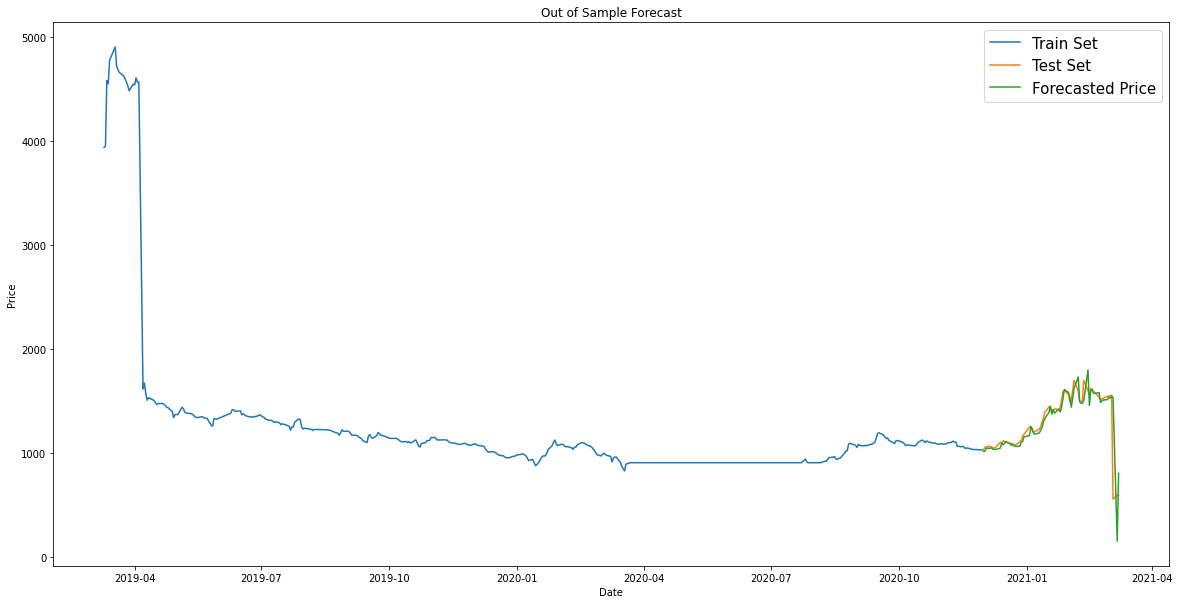

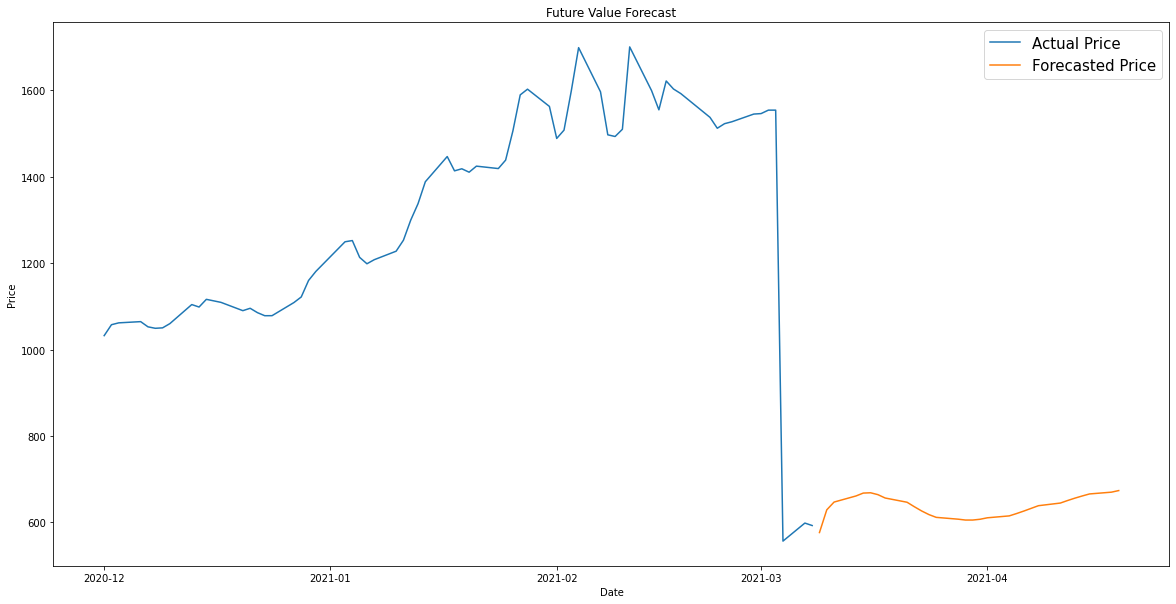

In [ ]:
# Instrument = input Instrument Name
# TRIAL = number of Epoch (trials),
# PATIENCE = after how many trials without any improvement in result the system should stop trial
# Back = number of previous data points to be used for forecasting
Stock_Forecast(Instrument="BATBC", TRIAL=1000, PATIENCE=100, Back=100)